# Apple Sentiment on Twitter: 2013 vs 2023
By Sarah Prusaitis, Rick Lataille, and Allison Ward

## Overview
- 2013 SXSW festival was a big success, very positive responses to new products
- What was the nature of that positive response, what did people like
- 10 years later, what is the public's response to Apple's new products

## Business Problem
- Has Apple maintained the public's support

## Data Limitations
- language shifts over time
- dataset only includes pos/neg, no neutral examples
- working with limited vocabulary, more robust approach would train on larger dataset
- pos/neg sentiment may reflect not just apple, but tech in general

# Analysis
- Using 2013 dataset, tagged positive or negative by human raters
    - Also including 10% of more recent tweets, labeled with VADER, to broaden vocabulary
- Applying fitted models to new Vision Pro datasets to determine sentiment balance

<span style="color: red;">NOTE: I ADDED PACKAGES IN THE NEXT CELL<span>

In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import re
import string
import langid

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer, word_tokenize, regexp_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import lightgbm as lgb

In [2]:
# Read original data
df1 = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'ISO-8859-1')

In [3]:
# Read synthetic data
df2 = pd.read_csv('data/Apple_Product_Negative_ Tweets_Sheet1.csv', encoding = 'ISO-8859-1')

<span style="color: red;">NOTE: I ADDED THE NEXT SEVERAL CELLS<span>

In [4]:
# Read Vision Pro data
df_vp = pd.read_csv('data/vision_pro_sentiment.csv',
                    encoding='ISO-8859-1',
                    usecols=['tweetText', 'mark']
                   ).rename(columns={'tweetText': 'tweet', 'mark':'sentiment'})

### Pre-processing
- Converting emoticons to unique strings
- Removing semantically meaningless patterns (mentions, links, etc)
- Adding limited additional stopwords that likely have no semantic meaning
- Tokenization, POS-tagging and Lemmatization
- TF-IDF Vectorization and Doc2Vec

In [5]:
# Keep only English-language tweets, then drop language column
df_vp['language'] = df_vp['tweet'].apply(lambda x: langid.classify(x)[0])
df_english = df_vp.loc[df_vp['language']=='en'].drop('language',axis=1).copy()

In [6]:
# Take 10% of Vision Pro tweets for training purposes
df_english_train = df_english.sample(n=round(len(df_vp)*.1))
df_english.drop(df_english_train.index, inplace=True)

In [7]:
# Convert Vision Pro labels to 1, 0
convert = {'Positive emotion':1, 'Negative emotion':0}
df_english['sentiment'] = df_english['sentiment'].map(convert)

In [8]:
# Rename columns for simplicity
df1 = df1.rename(columns = {'tweet_text': 'tweet', 
                         'emotion_in_tweet_is_directed_at': 'product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

In [9]:
# Combine rows into a single DataFrame
df = pd.concat([df1, df2], ignore_index = True)

In [10]:
# Combined and renamed Apple products and non Apple products 

df['product'] = df['product'].replace({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Other',
    'Other Google product or service': 'Other',
    'Android App': 'Other',
    'Android': 'Other'
})
#there are 5802 rows that are null - what should we do with those?

<span style="color: red;">NOTE: I THINK I MOVED THIS UP IN ORDER TO DROP AS MANY TWEETS AS EARLY AS POSSIBLE (MAKES SUBSEQUENT CODE RUN FASTER)<span>

In [11]:
# Filter DataFrame for only Apple tweets, and drop 'product column'
df_apple = df[df['product']=='Apple'].drop('product',axis=1).copy()

In [12]:
# Bring in Vision Pro tweets
df_apple = pd.concat([df_apple, df_english_train], ignore_index = True)

In [13]:
# Consolidate no emotion entries, and drop
df_apple['sentiment'] = df_apple['sentiment'].replace("I can't tell", "No emotion toward brand or product")
df_apple = df_apple.drop(df_apple[df_apple['sentiment'] == 'No emotion toward brand or product'].index).reset_index(drop=True)

In [14]:
df_apple['tweet'] = df_apple['tweet'].astype(str)

In [15]:
def replace_emoticons(text):
    # Define a dictionary mapping emoticons to their corresponding meanings
    emoticon_mapping = {
        ':D': 'emojismile',
        ':)': 'emojismile',
        ':-D': 'emojismile',
        ':\'': 'emojiunsure',
        ':p': 'emojitongue',
        ':P': 'emojitongue',
        ':(': 'emojisad'
        # Add more emoticons and their meanings as needed
    }
    pattern = re.compile('|'.join(re.escape(emoticon) for emoticon in emoticon_mapping.keys()))
    
    def replace(match):
        return emoticon_mapping[match.group(0)]

    return pattern.sub(replace, text)

<span style="color: red;">NOTE: I ADDED A LINE BELOW<span>

In [16]:
# Replace emoticons with mapped strings
df_apple['tweet'] = df_apple['tweet'].apply(replace_emoticons)
df_english['tweet'] = df_english['tweet'].apply(replace_emoticons)

In [17]:
def preprocess_tweet(tweet):
    # Remove links and mentions
    tweet = re.sub(r'http\S+|@\S+', '', tweet)
    
    # Remove {link}
    tweet = re.sub(r'\{link\}', '', tweet)
    
    # Replace &quot; with "
    tweet = tweet.replace('&quot;', '"')
    
    # Remove extra space between quotation mark and words
    tweet = re.sub(r'\s+"', '"', tweet)
    tweet = re.sub(r'"\s+', '"', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove punctuation
    tweet = re.sub(r'([^\w\s]|_)+', ' ', tweet)
    
    # Tokenize
    tokens = nltk.word_tokenize(tweet)
    
    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for word, pos in tagged_tokens:
        if pos.startswith('J'):
            pos = 'a'  # Adjective
        elif pos.startswith('V'):
            pos = 'v'  # Verb
        elif pos.startswith('N'):
            pos = 'n'  # Noun
        elif pos.startswith('R'):
            pos = 'r'  # Adverb
        else:
            pos = 'n'  # Default to noun
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_tokens.append(lemma)
    
    # Add additional stopwords
    additional_stopwords = {'w', 'u', 'amp', 'sxsw', 'rt'}  # amp = & 
    additional_stopwords.update('apple', 'sxswi', 'ipad', 'iphone')
    stop_words = set(stopwords.words('english')) | additional_stopwords
    
    # Remove stopwords
    tweet = [word for word in tokens if word not in stop_words]
    
    return tweet

<span style="color: red;">NOTE: I ADDED A LINE BELOW<span>

In [18]:
# Preprocess all tweets
df_apple['tweet'] = df_apple['tweet'].astype(str).apply(preprocess_tweet)
df_english['tweet'] = df_english['tweet'].astype(str).apply(preprocess_tweet)

In [19]:
# Label target with 1's and 0's
df_apple['target'] = df_apple['sentiment'].map({'Positive emotion': 1, 'Negative emotion': 0})

In [20]:
# train test split
X = df_apple['tweet']
y = df_apple['target'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [21]:
# Save tokenized data for Doc2Vec vectorizer
tokenized_train_data = X_train
tokenized_test_data = X_test

In [22]:
# Convert tokenized tweets back into strings for TfidfVectorizer
X_train_str = X_train.apply(lambda x: ' '.join(x))
X_test_str = X_test.apply(lambda x: ' '.join(x))

#### TF-IDF Vectorization
- Most common approach, more meaning than simple bag-of-words 

<span style="color: red;">NOTE: I CHANGED SOME OF THE INSTANTIATION ARGUMENTS<span>

In [23]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,2))

# Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

<span style="color: red;">NOTE: THIS CELL IS NEW, IT'S NEEDED IN ORDER TO RESTRICT VOCAB ON VISION PRO DATA<span>

In [24]:
# Get vocab for vision pro analysis and retrain
vocab = tfidf_vectorizer.get_feature_names_out()
tfidf_vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,2), vocabulary=vocab)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

#### Doc2Vec Vectorization
- This is a more sophisticated approach, captures additional meaning from document and word context
- GBM models can make use of this approach
- May not be better for smaller datasets

In [139]:
# Tag tokenized_tweets with an index for identification
tagged_train_data = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_train_data)]

# Initialize and train a Doc2Vec vectorizer
vectorizer = Doc2Vec(tagged_train_data, vector_size=50, window=2, min_count=1, workers=4, epochs=40)

In [140]:
# Infer vectors for testing set
test_vectors = np.array([vectorizer.infer_vector(doc_tokens) for doc_tokens in tokenized_test_data])

In [141]:
vectors = np.array([vectorizer.dv[i] for i in range(len(tagged_train_data))])

### Modeling
- Many potentially good models, not clear which one will work best
- Trying 5
    - Logistic Regression
    - Multinomial Naive Bayes
    - Support Vector Machines
    - Random Forest Classifier
    - LightGBM

#### Logistic Regression
- Performs well with binomial classification tasks
- Interpretable

In [99]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [100]:
y_preds_lr = logreg.predict(X_train_tfidf)
y_test_preds_lr = logreg.predict(X_test_tfidf)

In [101]:
print(classification_report(y_train, y_preds_lr))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2821
           1       0.93      0.87      0.90      2365

    accuracy                           0.91      5186
   macro avg       0.91      0.90      0.91      5186
weighted avg       0.91      0.91      0.91      5186



In [102]:
print(f'LogReg Train Accuracy: {accuracy_score(y_train, y_preds_lr):.1%}')

LogReg Train Accuracy: 90.8%


In [103]:
print(classification_report(y_test,y_test_preds_lr))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       709
           1       0.87      0.80      0.83       588

    accuracy                           0.85      1297
   macro avg       0.85      0.85      0.85      1297
weighted avg       0.85      0.85      0.85      1297



In [104]:
print(f'LogReg Test Accuracy: {accuracy_score(y_test,y_test_preds_lr):.1%}')

LogReg Test Accuracy: 85.1%


#### Multinomial Naive Bayes
- Good for multinomial classification problems

In [105]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

<span style="color: red;">NOTE: I THINK THERE WERE SOME TYPOS IN THE MULTI NB SECTION, I FIXED<span>

In [106]:
y_preds_mnb = mnb.predict(X_train_tfidf)
y_preds_test_mnb = mnb.predict(X_test_tfidf)

In [107]:
print(classification_report(y_train, y_preds_mnb))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2821
           1       0.90      0.88      0.89      2365

    accuracy                           0.90      5186
   macro avg       0.90      0.90      0.90      5186
weighted avg       0.90      0.90      0.90      5186



In [108]:
print(f'MultinomialNB Train Accuracy: {accuracy_score(y_train, y_preds_mnb):.1%}')

MultinomialNB Train Accuracy: 90.1%


In [109]:
print(classification_report(y_test, y_preds_test_mnb))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       709
           1       0.82      0.82      0.82       588

    accuracy                           0.84      1297
   macro avg       0.83      0.83      0.83      1297
weighted avg       0.83      0.84      0.83      1297



In [110]:
print(f'MultinomialNB Test Accuracy: {accuracy_score(y_test, y_preds_test_mnb):.1%}')

MultinomialNB Test Accuracy: 83.5%


#### Support Vector Machines
- Typically performs better in image or text classification task
- Not interpretable
- May not work as well on data with new features

<span style="color: red;">NOTE: I COMMENTED OUT INITIAL AND GRIDSEARCH CODE TO SPEED UP THE MODEL, WE CAN UNCOMMENT FOR THE FINAL AND LET IT RUN<span>

In [111]:
# svc = SVC(random_state=42)
# svc.fit(X_train_tfidf, y_train)

In [112]:
# y_preds_svc = svc.predict(X_train_tfidf)
# y_preds_test_svc = svc.predict(X_test_tfidf)

In [113]:
# print(classification_report(y_train, y_preds_svc))

In [114]:
# print(classification_report(y_test, y_preds_test_svc))

In [115]:
# params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#           'degree':[2,3,4],
#           'shrinking':[True,False],
#          }

In [116]:
# svc_grid = GridSearchCV(svc, param_grid=params, cv=5)

In [117]:
# %%time
# svc_grid.fit(X_train_tfidf, y_train)

In [118]:
# print(svc_grid.best_estimator_)
# print(svc_grid.best_params_)

In [119]:
svc_tuned = SVC(degree=2, kernel='poly', shrinking=True, random_state=42)
svc_tuned.fit(X_train_tfidf, y_train)

SVC(degree=2, kernel='poly', random_state=42)

In [120]:
y_preds_svc = svc_tuned.predict(X_train_tfidf)
y_preds_test_svc = svc_tuned.predict(X_test_tfidf)

In [121]:
print(classification_report(y_train, y_preds_svc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2821
           1       0.99      0.99      0.99      2365

    accuracy                           0.99      5186
   macro avg       0.99      0.99      0.99      5186
weighted avg       0.99      0.99      0.99      5186



In [122]:
print(f'SVM Train Accuracy: {accuracy_score(y_train, y_preds_svc):.1%}')

SVM Train Accuracy: 99.4%


In [123]:
print(classification_report(y_test, y_preds_test_svc))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88       709
           1       0.88      0.79      0.83       588

    accuracy                           0.86      1297
   macro avg       0.86      0.85      0.85      1297
weighted avg       0.86      0.86      0.86      1297



In [124]:
print(f'SVM Test Accuracy: {accuracy_score(y_test, y_preds_test_svc):.1%}')

SVM Test Accuracy: 85.7%


#### Random Forest
- Might be better for non-linear relationships

In [125]:
# rf = RandomForestClassifier()
# rf.fit(X_train_tfidf, y_train)

In [126]:
# y_preds_rf = rf.predict(X_train_tfidf)
# y_preds_test_rf = rf.predict(X_test_tfidf)

In [127]:
# print(classification_report(y_train, y_preds_rf))

In [128]:
# print(classification_report(y_test, y_preds_test_rf))

In [129]:
# rf_params = {'n_estimators':[10, 50, 100],
#              'criterion':['gini','entropy','log_loss'],
#              'max_depth':[5,10,20]
#             }

In [130]:
# rf_grid = GridSearchCV(rf, param_grid=rf_params, cv=5)

In [131]:
# rf_grid.fit(X_train_tfidf, y_train)

In [132]:
# print(rf_grid.best_estimator_)
# print(rf_grid.best_params_)

In [149]:
rf2 = RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=100, random_state=42)
rf2.fit(X_train_tfidf, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=20, random_state=42)

In [150]:
y_preds_rf2 = rf2.predict(X_train_tfidf)
y_preds_test_rf2 = rf2.predict(X_test_tfidf)

In [151]:
print(classification_report(y_train, y_preds_rf2))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      2821
           1       0.93      0.66      0.77      2365

    accuracy                           0.82      5186
   macro avg       0.85      0.81      0.81      5186
weighted avg       0.84      0.82      0.82      5186



In [152]:
print(f'Random Forest Train Accuracy: {accuracy_score(y_train, y_preds_rf2):.1%}')

Random Forest Train Accuracy: 82.2%


In [153]:
print(classification_report(y_test, y_preds_test_rf2))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       709
           1       0.87      0.63      0.73       588

    accuracy                           0.79      1297
   macro avg       0.81      0.78      0.78      1297
weighted avg       0.81      0.79      0.78      1297



In [154]:
print(f'Random Forest Test Accuracy: {accuracy_score(y_test, y_preds_test_rf2):.1%}')

Random Forest Test Accuracy: 79.0%


#### LightGBM
- Performs very well on very large datasets
- Excels at detecting complex patterns

In [142]:
train_data = lgb.Dataset(vectors, label=y_train.ravel())

In [143]:
params = {'boosting_type': 'gbdt',  # Traditional Gradient Boosting Decision Tree
          'objective': 'binary',    # Binary classification
          'metric': ['binary_error'],  # Evaluation metrics
          'lambda_l1': 0.5,
          'lambda_l2': 0.5,
          'max_bin': 100,
          'num_leaves': 20,         # Number of leaves in full trees
          'learning_rate': 0.05,    # Learning rate
          'feature_fraction': 0.9,  # Fraction of features to be used at each iteration
          'bagging_fraction': 0.8,  # Fraction of data to be used for each iteration
          'bagging_freq': 5,        # Frequency for bagging
          'verbose': 1              # Verbose output in the terminal
}

In [144]:
# Train the model
num_round = 100  # Number of boosting rounds
lgb_model = lgb.train(params, train_data, num_round)

[LightGBM] [Info] Number of positive: 2365, number of negative: 2821
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5000
[LightGBM] [Info] Number of data points in the train set: 5186, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.456035 -> initscore=-0.176313
[LightGBM] [Info] Start training from score -0.176313


In [145]:
# Make predictions and convert to binary
y_preds_lgb = lgb_model.predict(vectors, num_iteration=lgb_model.best_iteration)
y_preds_binary = [1 if prob > 0.5 else 0 for prob in y_preds_lgb]

print(classification_report(y_train, y_preds_binary))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2821
           1       0.86      0.84      0.85      2365

    accuracy                           0.86      5186
   macro avg       0.86      0.86      0.86      5186
weighted avg       0.86      0.86      0.86      5186



In [146]:
print(f'LightGBM Train Accuracy: {accuracy_score(y_train, y_preds_binary):.1%}')

LightGBM Train Accuracy: 86.3%


In [147]:
# Make predictions on test set
y_preds_test_lgb = lgb_model.predict(test_vectors, num_iteration=lgb_model.best_iteration)
y_preds_test_binary = [1 if prob > 0.5 else 0 for prob in y_preds_test_lgb]

print(classification_report(y_test, y_preds_test_binary))

              precision    recall  f1-score   support

           0       0.75      0.70      0.73       709
           1       0.67      0.71      0.69       588

    accuracy                           0.71      1297
   macro avg       0.71      0.71      0.71      1297
weighted avg       0.71      0.71      0.71      1297



In [148]:
print(f'LightGBM Test Accuracy: {accuracy_score(y_test, y_preds_test_binary):.1%}')

LightGBM Test Accuracy: 70.9%


### Modeling Conclusion
- LightGBM is bad
- SVM seems badly overfit
- Multinomial NB and Random Forest are okay
- Logistic Regression is best

<span style="color: red;">NOTE: EVERYTHING BELOW IS NEW<span>

### Vectorize vision pro tweets
- Use the *fitted* vectorizer to vectorize the Vision Pro tweets
- The vectorizer must be limited to only the vocabulary seen in the initial dataset
- Words not in the initial dataset will be dropped, which will limit the model's accuracy on unseen data

In [65]:
# Convert tokenized tweets back into strings for TfidfVectorizer
df_english['tweet_join'] = df_english['tweet'].apply(lambda x: ' '.join(x))

In [66]:
# Transform the new tweets with the fitted vectorizer
vp_vectored = tfidf_vectorizer.fit_transform(df_english['tweet_join'])

### Logistic Regression predictions

In [155]:
# Make predictions on new data
vp_preds = logreg.predict(vp_vectored)

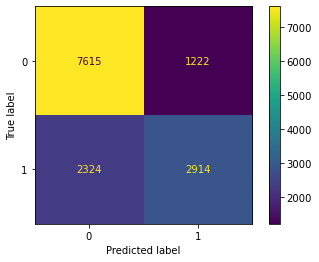

In [156]:
cm = confusion_matrix(df_english['sentiment'], vp_preds)
ConfusionMatrixDisplay(cm).plot();

In [157]:
print(classification_report(df_english['sentiment'], vp_preds))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      8837
           1       0.70      0.56      0.62      5238

    accuracy                           0.75     14075
   macro avg       0.74      0.71      0.72     14075
weighted avg       0.74      0.75      0.74     14075



In [159]:
print(f'LogReg Accuracy vs VADER: {accuracy_score(df_english["sentiment"], vp_preds):.1%}')

LogReg Accuracy vs VADER: 74.8%
